# Import Libraries

In [215]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

import requests
import json
from PIL import Image
import io

import warnings
warnings.filterwarnings('ignore')

# GPU Config

In [180]:
# Listing all the devices
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA not available")

Device count: 1
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU


In [181]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Adverserial Attack on CIFAR

## AlexNet for CIFAR-10

In [182]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()

        # Conv layer
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            # Layer 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            #Layers 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 1
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # Dense layer
        self.classifier=nn.Sequential(
            nn.Dropout(p=0.5),
            
            nn.Linear(256*4*4, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1) #flatten the output of conv layer
        x = self.classifier(x)
        return x


## Data Preparation

In [183]:
if(0):
    train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=50000)
    
    data = next(iter(train_loader))[0]
    
    mean = data.mean(dim=(0,2,3,))
    std = data.std(dim=(0,2,3,))
    
    print(f"Mean: {mean}")
    print(f"Std: {std}")

Mean: tensor([0.4914, 0.4822, 0.4465]) <br>
Std: tensor([0.2470, 0.2435, 0.2616])

In [184]:
def prepare_data(batch_size=128):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)

    # train transformer
    transform_train = transforms.Compose([
        # Data Augmentation for a robust model
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # image to tensor
        transforms.Normalize(mean, std) # Standarization for effecient training
    ])

    # test transformer
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # trainset loading
    tarinset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(tarinset, batch_size=batch_size, shuffle=True, num_workers=2) # num_workers is the number of parallel subprocessor

    # testset loading
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2) # num_workers is the number of parallel subprocessor

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

## Model training on CIFAR Original Dataset

In [185]:
# function for training the model
def train_cifar_model(model, trainloader, criterion, optimizer, scheduler, device, weights_path, epochs=15):
    print(f"Starting training for {epochs} epochs on {device}...")
    
    start_time = time.time()
    model.to(device)
    for epoch in range(epochs):
        model.train() # set model to training mode (enables dropout)
        running_loss = 0.0 # for smooth trajectory
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad() # resets (clear) the gradients of all parameters for next backpropogation

            # Forward Propopgation
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Back Propogation
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch + 1}/{epochs} | Loss: {running_loss/len(trainloader):.3f}')
        scheduler.step() # learning rate decay
    end_time = time.time()
    print(f"Training finished ({(end_time-start_time):.1f}s) - Saving trained weights...")

    torch.save(model.state_dict(), weight_path)
    print(f"Model weights saved to {weight_path}")   

In [186]:
# torch.save(model.state_dict(), "saved_models/cifar_alexnet.pth")

In [187]:
# function for evaluation 
def eval_model(model, testloader):
    model.eval() # set model to evaluation mode
    correct=0
    total=0
    with torch.no_grad(): #Disable gradient calculation
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy of the Model on the 10000 test images: {100*correct//total}%")

In [188]:
# Training
WEIGHTS_PATH = "saved_models/cifar_alexnet.pth"
EPOCHS = 15
LEARNING_RATE = 0.01
BATCH_SIZE = 128

# Prepare Data
trainloader, testloader, classes = prepare_data(batch_size=BATCH_SIZE)

# Model Initialization
model = AlexNetCIFAR(num_classes=len(classes))

# if weight exists, then skip training
if os.path.exists(WEIGHTS_PATH):
    print(f"Weight file found at {WEIGHTS_PATH} - Loading weights...")
    model.load_state_dict(torch.load(WEIGHTS_PATH))
    model.to(DEVICE)
    print(f"Weights loaded successfully. Skipping training.")
else:
    criterion = nn.CrossEntropyLoss() # multiclass classification
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) # learning reat weight decay scheduler
    
    train_model(model=model,
                trainloader=trainloader,
                criterion=criterion,
                optimizer=optimizer, 
                scheduler=scheduler,
                device=DEVICE,
                weights_path=WEIGHTS_PATH,
                epochs=EPOCHS)

Files already downloaded and verified
Files already downloaded and verified
Weight file found at saved_models/cifar_alexnet.pth - Loading weights...
Weights loaded successfully. Skipping training.


Files already downloaded and verified <br>
Files already downloaded and verified <br>
Starting training for 15 epochs on cuda... <br>
Epoch 1/15 | Loss: 2.119 <br>
Epoch 2/15 | Loss: 1.690 <br>
Epoch 3/15 | Loss: 1.412 <br>
Epoch 4/15 | Loss: 1.207 <br>
Epoch 5/15 | Loss: 1.038 <br>
Epoch 6/15 | Loss: 0.839 <br>
Epoch 7/15 | Loss: 0.797 <br>
Epoch 8/15 | Loss: 0.773 <br>
Epoch 9/15 | Loss: 0.746 <br>
Epoch 10/15 | Loss: 0.726 <br>
Epoch 11/15 | Loss: 0.692 <br>
Epoch 12/15 | Loss: 0.684 <br>
Epoch 13/15 | Loss: 0.682 <br>
Epoch 14/15 | Loss: 0.679 <br>
Epoch 15/15 | Loss: 0.675 <br>

In [189]:
# Testing
eval_model(model, testloader)

Accuracy of the Model on the 10000 test images: 75%


## Untargeted Adversarial Attack Effect on CIFAR-10 using Fast Gradient Sign Method (FGSM)

### CIFAR-10 Config

In [190]:
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]
# CIFAR_CLAMP_MIN = -2.5
# CIFAR_CLAMP_MAX = 2.5
CIFAR_CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
WEIGHTS_PATH = "saved_models/cifar_alexnet.pth"

### FGSM Method

In [191]:
# FGSM method to add noise to the image for adversarial attack
def fgsm_attack(image, epsilon, data_grad, clamp_min, clamp_max, targeted=False):
    sign_data_grad = data_grad.sign()
    if targeted: perturbed_image = image-epsilon*sign_data_grad
    else: perturbed_image = image+epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, clamp_min, clamp_max) # maintians original range[0,1]
    return perturbed_image

### Helper function for Visualization 

In [192]:
# function to display the image
def imshow_unnormalized(tensor, mean, std, title=None):
    # clone, move to cpu, convert to numpy
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze(0) # remove batch dimension

    # Un-normalize
    image = std*image.transpose(1,2,0) + mean # channel, height, weight -> height, weight, channel (PyTorch tensors are C,H,W but Matplotlib needs H,W,C)

    image = np.clip(image, 0, 1)

    # plot
    plt.imshow(image)
    plt.title(title)

In [193]:
def get_saliency_map(model, image, label_idx):
    model.zero_grad()
    output = model(image)
    score = output[0, label_idx]
    score.backward()
    saliency = image.grad.data.abs()
    return saliency

In [226]:
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

### Data Preparation and Model Load

In [194]:
def get_test_loader(batch_size=128):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2470, 0.2435, 0.2616)
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2) # num_workers is the number of parallel subprocessor

    return testloader
    

In [195]:
def load_cifar_model(weights_path, device):
    if not os.path.exists(weights_path):
        print(f"Error: Weight file not found at {weights_path}")
        return None
        
    print(f"Loading weights from {weights_path}...")
    model = AlexNetCIFAR(num_classes=10).to(device)
    model.load_state_dict(torch.load(weights_path))
    model.eval()
    print("Model loaded successfully.")
    return model

### Untargeted Attack Effect on AlexNet (Single Image)

In [196]:
def run_single_image_attack_cifar(model, testloader, classes, device, epsilon, mean, std):
    print(f"Running Single Image Attack with strength (Epsilon: {epsilon})")
    criterion = nn.CrossEntropyLoss()

    # get one image from test loader
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    original_image, original_label = None, None
    for i in range(len(images)):
        img = images[i].unsqueeze(0).to(DEVICE)
        lbl = labels[i].unsqueeze(0).to(DEVICE)
        output = model(img)
        _, pred_idx = torch.max(output, 1)
        if pred_idx.item() == lbl.item():
            original_image, original_label = img, lbl
            break
            
    if original_image is None:
        print("Could not find a correctly classified image in the first batch.")
        return
    
    # Original prediction (without adversarial attack)
    original_output = model(original_image)
    _, original_pred_idx = torch.max(original_output, 1)
    original_pred_class = classes[original_pred_idx.item()]
    original_confidence = F.softmax(original_output, dim=1).max().item()
    # true_label_class = classes[original_label.item()]
    print(f"Before Attack: '{original_pred_class}', Confidence: {original_confidence*100:.1f}%")

    # Generate Adversarial image
    original_image.requires_grad = True
    loss = criterion(model(original_image), original_label)
    model.zero_grad()
    loss.backward()

    data_grad = original_image.grad.data
    perturbed_image = fgsm_attack(original_image, epsilon, data_grad, -2.5, 2.5)

    # Adversarial image prediction
    attack_output = model(perturbed_image)
    _, attack_pred_idx = torch.max(attack_output, 1)
    attack_pred_class = classes[attack_pred_idx.item()]
    attack_confidence = F.softmax(attack_output, dim=1).max().item()
    print(f"After Attack: '{attack_pred_class}', Confidence: {attack_confidence*100:.1f}%")

    # Saliency Maps
    original_img_for_saliency = original_image.detach().clone().requires_grad_(True)
    saliency_original_grad = get_saliency_map(model, original_img_for_saliency, original_pred_idx.item())
    perturbed_img_for_saliency = perturbed_image.detach().clone().requires_grad_(True)
    saliency_adversarial_grad = get_saliency_map(model, perturbed_img_for_saliency, attack_pred_idx.item())

    # Viz the Effect
    noise = perturbed_image - original_image
    # Normalize noise to [0, 1] for visualization
    noise_viz = (noise.abs() - noise.abs().min()) / (noise.abs().max() - noise.abs().min())

    plt.figure(figsize=(12, 9))
    plt.suptitle(f"CIFAR-10 Adversarial Untargeted Attack on AlexNet (FGSM - Epsilon: {epsilon})", fontsize=16)
    
    plt.subplot(2,3,1)
    imshow_unnormalized(original_image, mean, std, title=f"Original Image\n'{original_pred_class}' ({original_confidence*100:.1f}%)")

    plt.subplot(2, 3, 2)
    imshow_unnormalized(noise_viz, mean, std, title=f"Perturbation (Noise)\n(Amplified)")
    
    plt.subplot(2, 3, 3)
    imshow_unnormalized(perturbed_image, mean, std, title=f"Adversarial Image\n'{attack_pred_class}' ({attack_confidence*100:.1f}%)")

    saliency_orig_map, _ = torch.max(saliency_original_grad.squeeze(0), dim=0)
    plt.subplot(2, 3, 4)
    plt.imshow(saliency_orig_map.cpu().numpy(), cmap='hot')
    plt.title(f"Saliency for '{original_pred_class}'\n(Original Pred, Conf: {original_confidence*100:.1f}%)", fontsize=10)
    plt.axis('off')
    
    saliency_adv_map, _ = torch.max(saliency_adversarial_grad.squeeze(0), dim=0)
    plt.subplot(2, 3, 5)
    plt.imshow(saliency_adv_map.cpu().numpy(), cmap='hot')
    plt.title(f"Saliency for '{attack_pred_class}'\n(Adversarial Pred, Conf: {attack_confidence*100:.1f}%))", fontsize=10)
    plt.axis('off')

    plt.show()
    

Files already downloaded and verified
Loading weights from saved_models/cifar_alexnet.pth...
Model loaded successfully.
Running Single Image Attack with strength (Epsilon: 0.1)
Before Attack: 'cat', Confidence: 80.4%
After Attack: 'dog', Confidence: 85.4%


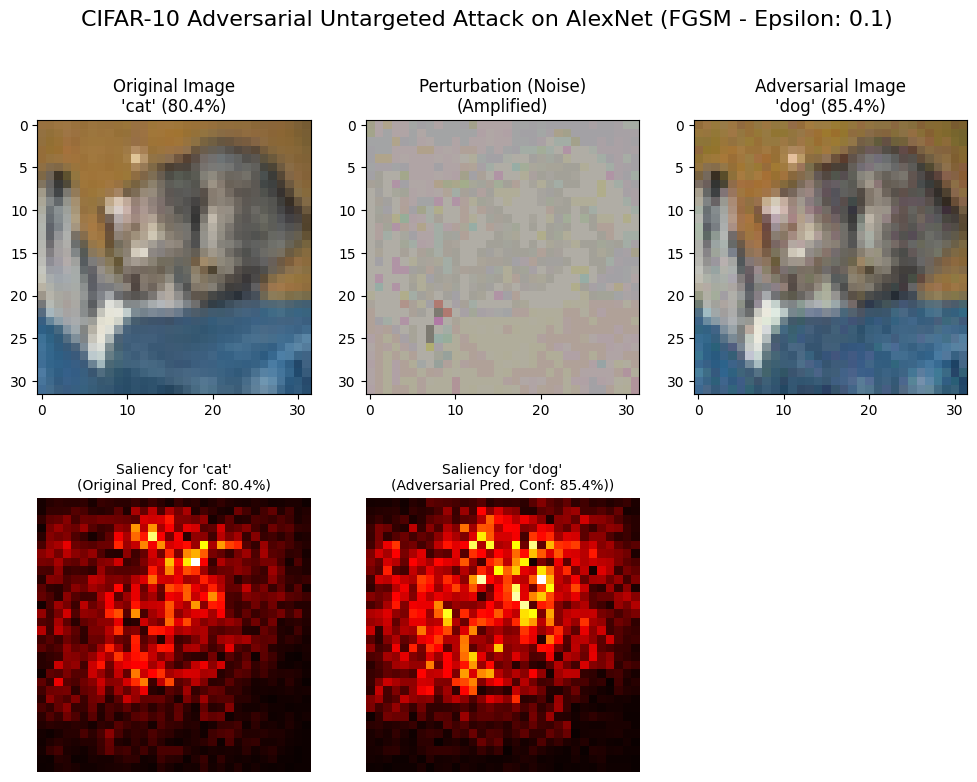

In [197]:
# main block to execute the Adversarial attack on single image
EPSILON = 0.1 # 0.01, 0.05, 0.1

testloader = get_test_loader()
model = load_cifar_model(WEIGHTS_PATH, DEVICE)
if model: run_single_image_attack_cifar(model, testloader, CIFAR_CLASSES, DEVICE, EPSILON, CIFAR_MEAN, CIFAR_STD)
else: print("Cannot run attack because the model did not load.")

### Untargeted Attack Effect on AlexNet (Batch Image)

In [227]:
def run_cifar_batch_attack(weights_path, epsilon):
    print("\nRunning CIFAR-10 Batch Attack")
    
    #Load Model and Data
    attack_model = AlexNetCIFAR().to(DEVICE)
    attack_model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    attack_model.eval()
    criterion = nn.CrossEntropyLoss()
    print("Loaded trained CIFAR-10 model.")

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    
    all_true_labels = []
    all_clean_preds = []
    all_adv_preds = []
    
    print(f"Iterating over {len(testset)} test images.")
    for images, labels in testloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        all_true_labels.extend(labels.cpu().numpy())
        
        # Before (Original Prediction)
        with torch.no_grad():
            clean_outputs = attack_model(images)
            _, clean_predicted = torch.max(clean_outputs.data, 1)
            all_clean_preds.extend(clean_predicted.cpu().numpy())

        # After (Adversarial Prediction)
        images.requires_grad = True
        outputs = attack_model(images)
        loss = criterion(outputs, labels)
        attack_model.zero_grad()
        loss.backward()
        data_grad = images.grad.data
        
        perturbed_images = fgsm_attack(images, epsilon, data_grad, 
                                       -2.5, 2.5, targeted=False)
        
        with torch.no_grad():
            attack_outputs = attack_model(perturbed_images)
            _, attack_predicted = torch.max(attack_outputs.data, 1)
            all_adv_preds.extend(attack_predicted.cpu().numpy())

    print("Batch processing complete.")

    # Accuracy
    clean_accuracy = np.mean(np.array(all_clean_preds) == np.array(all_true_labels))
    adv_accuracy = np.mean(np.array(all_adv_preds) == np.array(all_true_labels))

    print("\n--- Accuracy Results ---")
    print(f"Original Image Accuracy:   {clean_accuracy*100:.2f}%")
    print(f"Adversarial Image Accuracy: {adv_accuracy*100:.2f}%")
    
    # Confusion Matrices
    cm_clean = confusion_matrix(all_true_labels, all_clean_preds)
    cm_adv = confusion_matrix(all_true_labels, all_adv_preds)
    
    # Plot
    plot_confusion_matrix(cm_clean, CIFAR_CLASSES, f"CIFAR-10 Confusion Matrix (Original)\nAccuracy: {clean_accuracy*100:.2f}%")
    plot_confusion_matrix(cm_adv, CIFAR_CLASSES, f"CIFAR-10 Confusion Matrix (Adversarial, e={epsilon})\nAccuracy: {adv_accuracy*100:.2f}%")

# ImageNet Adverserial Attack on ResNet

## ImageNet Config

In [198]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# IMAGENET_CLAMP_MIN = -2.2
# IMAGENET_CLAMP_MAX = 2.7

## ResNet for ImageNet

In [199]:
class ResNet18ImageNet(nn.Module):
    def __init__(self):
        super(ResNet18ImageNet, self).__init__()
        # Load the pre-trained ResNet-18 model directly from torchvision
        self.model = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        )

    def forward(self, x):
        return self.model(x)

## ImageNet Data Preparation

In [200]:
# function to laod imagenet classes
def get_imagenet_classes():
    url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        classes_json = response.json()
        return [classes_json[str(k)][1] for k in range(1000)]
    except Exception as e:
        print(f"Failed to download class names: {e}. Using dummy names.")
        return [f"class_{i}" for i in range(1000)]


In [201]:
# get image
def get_sample_imagenet_image(transform=None):
    img_url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
    print("Downloading sample ImageNet image ('dog.jpg')...")
    try:
        response = requests.get(img_url, timeout=10)
        response.raise_for_status()
        img_pil = Image.open(io.BytesIO(response.content)).convert('RGB')

        if transform is None:
            transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
            ])

        image_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
        label_tensor = torch.tensor([207]).to(DEVICE)  # golden_retriever
        return image_tensor, label_tensor, img_pil
    except Exception as e:
        print(f"Error downloading sample image: {e}")
        return None, None, None

## Targeted Adverserial attack on ImageNet using Projected Gradient Descent (PGD) technique

### PGD Attack function

In [202]:
def pgd_attack(model, x, target_label, epsilon, alpha, steps, restarts):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    x_adv = x.clone()

    for _ in range(restarts):
        delta = torch.zeros_like(x).uniform_(-epsilon, epsilon).to(DEVICE)
        delta.requires_grad = True

        for _ in range(steps):
            outputs = model(x_adv + delta)
            loss = criterion(outputs, target_label)
            model.zero_grad()
            loss.backward()
            grad = delta.grad.data

            delta.data = delta - alpha * grad.sign()
            delta.data = torch.clamp(delta, -epsilon, epsilon)
            delta.data = torch.clamp(x + delta, 0, 1) - x
            delta.grad.zero_()

        x_adv = x + delta.detach()

    return torch.clamp(x_adv, 0, 1)

### Helper function for Vizualization

In [203]:
def show_confidence_bar(original_probs, adv_probs, classes, topk=5, title=None):
    orig_topk = torch.topk(original_probs, topk)
    adv_topk = torch.topk(adv_probs, topk)
    labels = [classes[i] for i in orig_topk.indices.cpu().numpy()]

    plt.figure(figsize=(10,5))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(1,2,1)
    plt.barh(labels, orig_topk.values.cpu().numpy())
    plt.title("Original (Top-5)")
    plt.gca().invert_yaxis()
    
    labels_adv = [classes[i] for i in adv_topk.indices.cpu().numpy()]
    plt.subplot(1,2,2)
    plt.barh(labels_adv, adv_topk.values.cpu().numpy(), color="orange")
    plt.title("Adversarial (Top-5)")
    plt.gca().invert_yaxis()
    plt.show()

### Targeted Attack Effect

In [204]:
def run_single_image_attack_imagenet(model, classes, mean, std, target_label_name="ostrich", epsilon=8/255.0, alpha=2/255.0, steps=40, restarts=1, ):
    original_image, label, img_pil = get_sample_imagenet_image()
    if original_image is None:
        return

    print(f"Target class: {target_label_name}")
    target_label_idx = classes.index(target_label_name)
    target_label = torch.tensor([target_label_idx]).to(DEVICE)


    with torch.no_grad():
        original_output = model(original_image)
        original_probs = F.softmax(original_output, dim=1)
        original_pred = original_probs.argmax(dim=1).item()
        original_confidence = original_probs[0, original_pred]
        print(f"Before attack: '{classes[original_pred]}', Confidence: {original_confidence*100:.1f}%")

    # Adversarial image prediction
    perturbed_image = pgd_attack(model, original_image, target_label, epsilon, alpha, steps, restarts)
    with torch.no_grad():
        attack_output = model(perturbed_image)
        attack_probs = F.softmax(attack_output, dim=1)
        attack_pred = attack_probs.argmax(dim=1).item()
        attack_confidence = attack_probs[0, attack_pred]
        print(f"After attack: '{classes[attack_pred]}', Confidence: {attack_confidence*100:.1f}%")

    # Saliency Maps
    original_img_for_saliency = original_image.detach().clone().requires_grad_(True)
    saliency_original_grad = get_saliency_map(model, original_img_for_saliency, original_pred)
    perturbed_img_for_saliency = perturbed_image.detach().clone().requires_grad_(True)
    saliency_adversarial_grad = get_saliency_map(model, perturbed_img_for_saliency, attack_pred)

    # Viz the Effect
    noise = (perturbed_image - original_image).abs()
    
    plt.figure(figsize=(12, 9))
    plt.suptitle(f"ImageNet Adversarial Targeted Attack on ResNet (PGD - Epsilon: {epsilon:.2f})", fontsize=16)
    
    plt.subplot(2,3,1)
    imshow_unnormalized(original_image, mean, std, title=f"Original Image\n'{classes[original_pred]}' ({original_confidence*100:.1f}%)")

    plt.subplot(2,3,2)
    imshow_unnormalized(noise*10, mean, std, "Perturbation (Noise)\n(x10 amplified)")
    
    plt.subplot(2,3,3);
    imshow_unnormalized(perturbed_image, mean, std, title=f"Adversarial Image\n'{classes[attack_pred]}' ({attack_confidence*100:.1f}%)")

    saliency_orig_map, _ = torch.max(saliency_original_grad.squeeze(0), dim=0)
    plt.subplot(2, 3, 4)
    plt.imshow(saliency_orig_map.cpu().numpy(), cmap='hot')
    plt.title(f"Saliency for '{classes[original_pred]}'\n(Original Pred, Conf: {original_confidence*100:.1f}%)", fontsize=10)
    plt.axis('off')
    
    saliency_adv_map, _ = torch.max(saliency_adversarial_grad.squeeze(0), dim=0)
    plt.subplot(2, 3, 5)
    plt.imshow(saliency_adv_map.cpu().numpy(), cmap='hot')
    plt.title(f"Saliency for '{classes[attack_pred]}'\n(Adversarial Pred, Conf: {attack_confidence*100:.1f}%))", fontsize=10)
    plt.axis('off')
    plt.show()

    show_confidence_bar(original_probs[0], attack_probs[0], classes, title=f"Top 5 predicted class - ResNet (ImageNet)")

Target class: ostrich
Before attack: 'Samoyed', Confidence: 88.5%
After attack: 'ostrich', Confidence: 89.1%


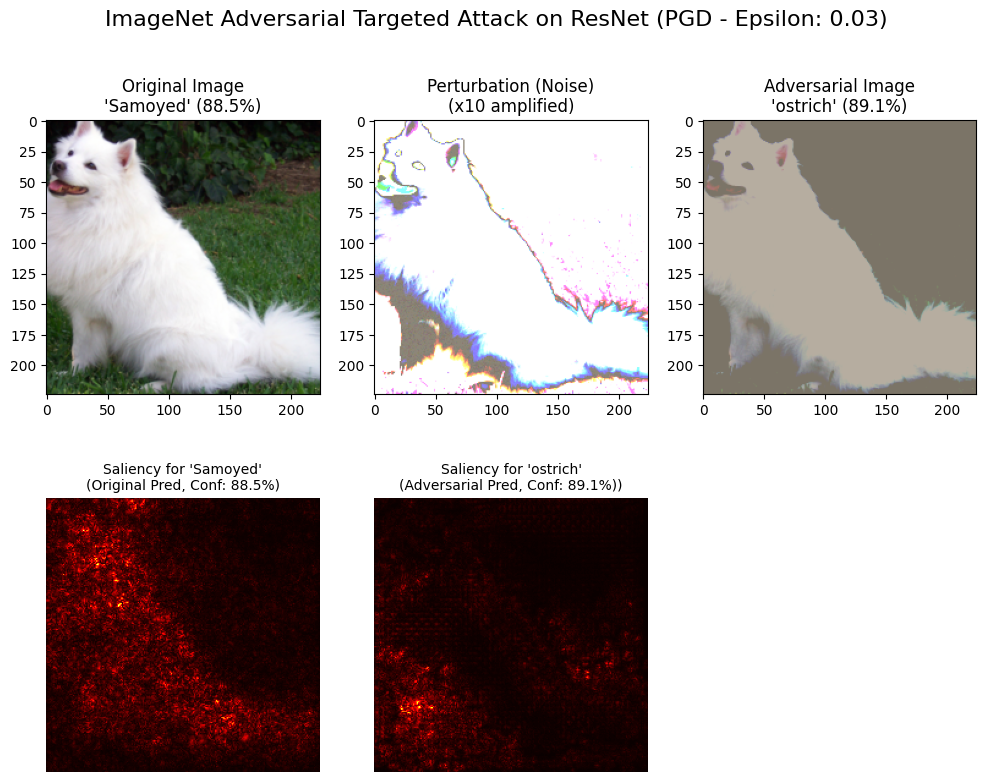

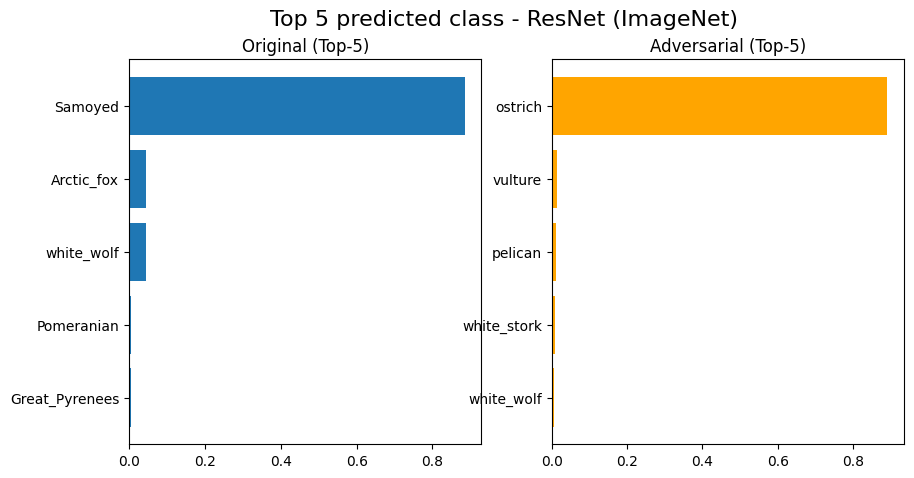

In [205]:
IMAGENET_CLASSES = get_imagenet_classes()
resnet_model = ResNet18ImageNet().to(DEVICE).eval()
target_label_name="ostrich"
epsilon=8/255.0
alpha=2/255.0
steps=40
restarts=1

if resnet_model:
    run_single_image_attack_imagenet(resnet_model,IMAGENET_CLASSES,IMAGENET_MEAN,IMAGENET_STD,target_label_name,epsilon,alpha,steps,restarts)
else: print("Cannot run attack because the model did not load.")